In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Suppress annoying warnings from pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Data Cleaning

Here we map the names of the animal classes in ```class.csv``` to their corresponding ids in ```zoo.csv```.

In [ ]:
animals = pd.read_csv('../data/zoo.csv')
animals.drop(['animal_name'], axis=1, inplace=True)

In [173]:
animal_names = pd.read_csv('../data/zoo.csv').animal_name

In [3]:
classes = pd.read_csv('../data/class.csv')
classes.columns = [col.lower() for col in classes.columns]
classes = classes[['class_number', 'class_type']].rename({'class_type':'class_name', 'class_number':'class_type'}, axis=1)

In [4]:
animals = animals.merge(classes)

# Class Counts
Amphibians and reptiles have very few observations, and they are objectively pretty similar animals. I imagine that they will be tough to tell apart. Bugs and invertebrates are probably in a similar situation.

In [5]:
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex

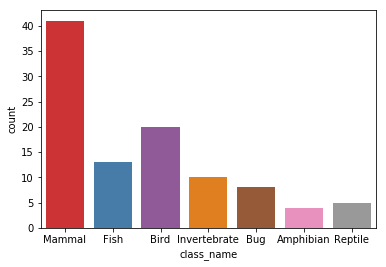

In [6]:
cmap = cm.get_cmap('Set1', 7)
colors = [rgb2hex(cmap(i)[:3]) for i in range(7)]
sns.countplot(x='class_name', data=animals, palette=colors)

# Correlation Matrix

Milk has strong correlations with both hair and eggs. This might be an indidcation that we can drop one of the variables.

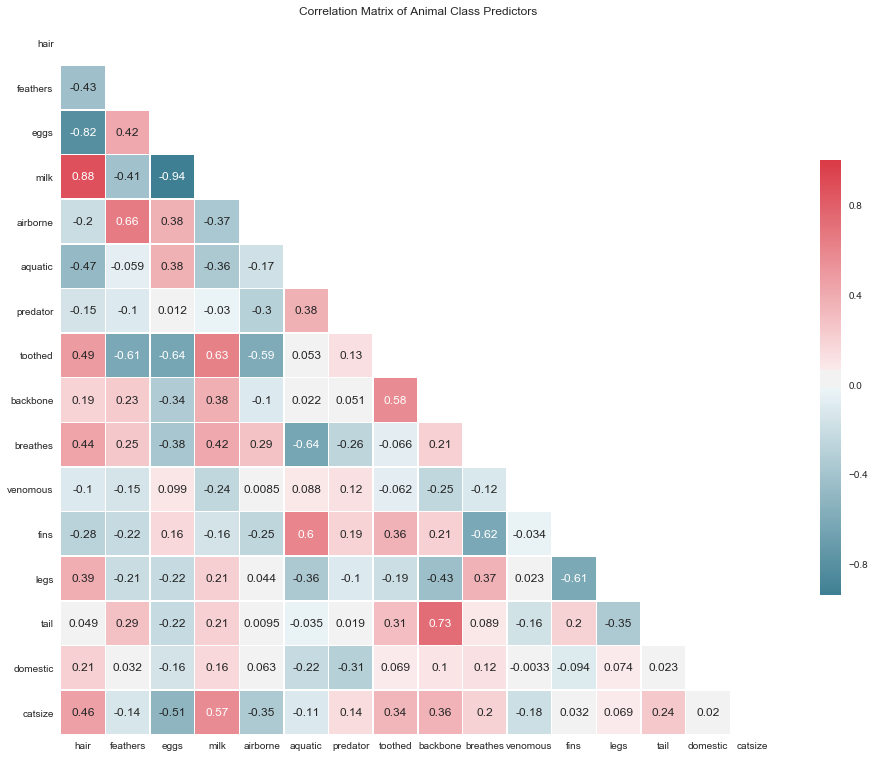

In [278]:
# Compute the correlation matrix
corr = animals[features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax = ax.set_title('Correlation Matrix of Animal Class Predictors')

# Dimension Reduction

I'll start by trying some of the typical approaches for dimensionality reduction to see if we can tease out some separation amongst the classes.

In [8]:
from sklearn.decomposition import FactorAnalysis, PCA, NMF, TruncatedSVD as LSA
from sklearn.cross_decomposition import CCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [148]:
def plot_decomp(X, y, targets, subplot, transform, dims):
    
    if transform == "PCA":
        X_r = PCA(n_components=dims).fit_transform(X)
    elif transform == "NMF":
        X_r = NMF(n_components=dims).fit_transform(X)
    elif transform == "LDA":
        X_r = LDA(n_components=dims).fit(X, y).transform(X)
    elif transform == "FA":
        X_r = FactorAnalysis(n_components=dims).fit(X, y).transform(X)
    elif transform == "LSA":
        X_r = LSA(n_components=dims).fit(X, y).transform(X)
    elif transform == "CCA":
        X_r = CCA(n_components=dims).fit(X, y).transform(X)
    else:
        raise ValueError
    
    n_classes = len(targets)
    
    cmap = cm.get_cmap('Set1', n_classes)
    colors = [rgb2hex(cmap(i)[:3]) for i in range(n_classes)]
        
    if dims == 2:
        lw = 2
        plt.subplot(2, 2, subplot)

        for color, i, target in zip(colors, np.arange(1, n_classes+1), targets):
            plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw, label=target)
            if transform != 'CCA':
                bucket = X_r[y == i, :]
                hull = ConvexHull(bucket)
                for j in hull.simplices:
                    plt.plot(bucket[j,0], bucket[j,1], color)
            

    elif dims == 3:
        lw = 3
        plt.subplot(2, 2, subplot, projection='3d')

        for color, i, target in zip(colors, np.arange(1, n_classes+1), targets):
            plt.scatter(X_r[y == i, 0], X_r[y == i, 1], X_r[y==i, 2], color=color, alpha=.8, lw=lw, label=target)

    else:
        raise ValueError

    if subplot == 1:
        plt.legend(loc='best', shadow=False, scatterpoints=1)

    plt.title(transform + ' of Animals dataset')

In [149]:
def plot_decomp_grid(X, y, targets, transforms=['PCA', 'LDA', 'CCA', 'FA'], dims=2):
    plt.figure(figsize=(16, 12))
    for i,tf in enumerate(transforms):
        plot_decomp(X, y, targets, i+1, tf, dims)

    plt.show()

## 2D Plots

### PCA, LDA, CCA, and LSA

In [150]:
targets = animals.class_name.unique()
features = animals.drop(['class_type', 'class_name'], axis=1).columns

dummy_legs = pd.get_dummies(animals.legs).loc[:, 1:]
dummy_legs.columns = [str(col) + '_legs'  for col in dummy_legs.columns]
X = animals.drop(['legs', 'class_name', 'class_type'], axis=1).join(dummy_legs)

# X = animals[features].as_matrix()
y = animals.class_type.as_matrix()

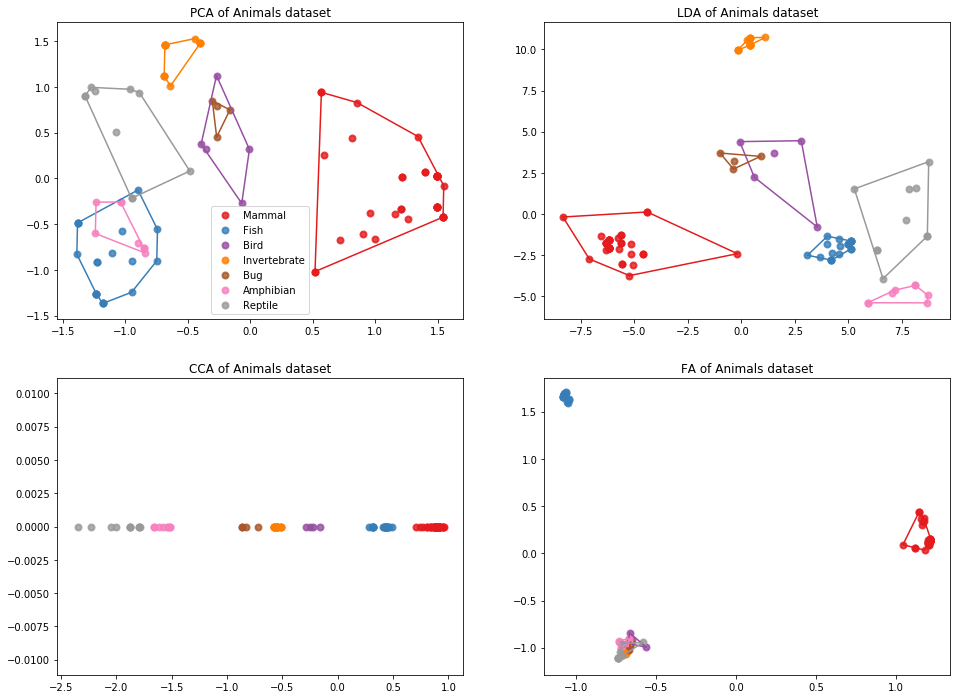

In [151]:
plot_decomp_grid(X, y, targets)

## 3D LDA Plot

In [26]:
from mpl_toolkits.mplot3d import Axes3D

In [27]:
targets = ['Mammal', 'Bird', 'Reptile', 'Fish', 'Amphibian', 'Bug', 'Invertebrate']
n_classes = len(targets)
features = animals.drop(['class_type', 'class_name'], axis=1).columns

X = animals.drop(['legs', 'class_name', 'class_type'], axis=1).join(dummy_legs)
y = animals.class_type.as_matrix()

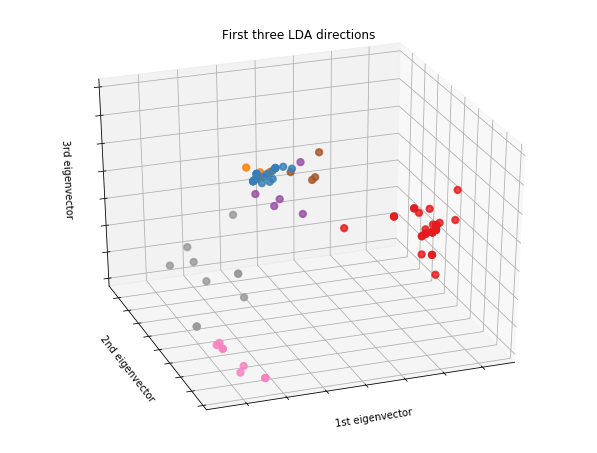

In [28]:
X_r = LDA(n_components=3).fit(X, y).transform(X)

cmap = cm.get_cmap('Set1', n_classes)
colors = [rgb2hex(cmap(i)[:3]) for i in range(n_classes)]

fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
for color, i, target in zip(colors, np.arange(1, n_classes+1), targets):
    ax.scatter(X_r[y == i, 0], X_r[y == i, 1], X_r[y==i, 2], color=color, alpha=.8, lw=2, label=target, s=40)

ax.set_title("First three LDA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()


# Manifold Learning
Manifold learning is an approach to non-linear dimensionality reduction. Algorithms for this task are based on the idea that the dimensionality of many data sets is only artificially high. However, they tend to be better for visualization than for predictions.

## t-SNE (t-distributed Stochastic Neighbor Embedding)
t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results. [Inspiration](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py)

In [279]:
from sklearn.manifold import TSNE

In [32]:
targets = ['Mammal', 'Bird', 'Reptile', 'Fish', 'Amphibian', 'Bug', 'Invertebrate']
n_classes = len(targets)
features = animals.drop(['class_type', 'class_name'], axis=1).columns

X = animals.drop(['legs', 'class_name', 'class_type'], axis=1).join(dummy_legs)
y = animals.class_type.as_matrix()

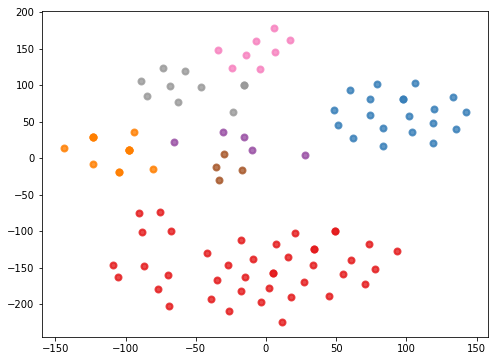

In [33]:
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_r = tsne.fit_transform(X)

lw = 2
plt.figure(figsize=(8,6))

for color, i, target in zip(colors, np.arange(1, n_classes+1), targets):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw, label=target)

I'm curious to see if things change when using LDA as for our init parameter.

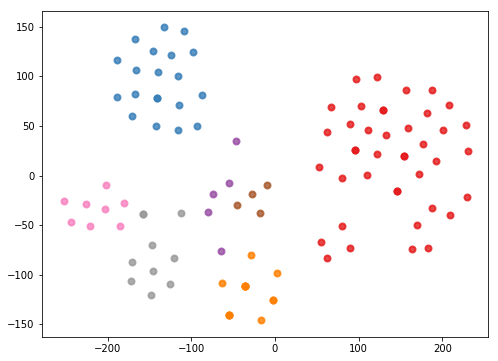

In [34]:
init = LDA(n_components=2).fit(X, y).transform(X)
tsne = TSNE(n_components=2, init=init, random_state=0)
X_r = tsne.fit_transform(X)

lw = 2
plt.figure(figsize=(8,6))

for color, i, target in zip(colors, np.arange(1, n_classes+1), targets):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw, label=target)

# Is our data linearly separable?

We can check if our model is linearly separable with three methods:

### Single Layer Perceptron

If our data is linearly separable, then we should be able to run it through a convergent single layer perceptron. A single layer perceptron will only converge if the input vectors are linearly separable. In this state, all input vectors would be classified correctly indicating linear separability. We will apply it on the entire dataset instead of splitting into train/test since our intent is to test for linear separability among the classes and not to build a model for future predictions. We don't have to do any feature scaling because all of our inputs are binary.

In [180]:
animals.class_name.unique()

array(['Mammal', 'Fish', 'Bird', 'Invertebrate', 'Bug', 'Amphibian',
       'Reptile'], dtype=object)

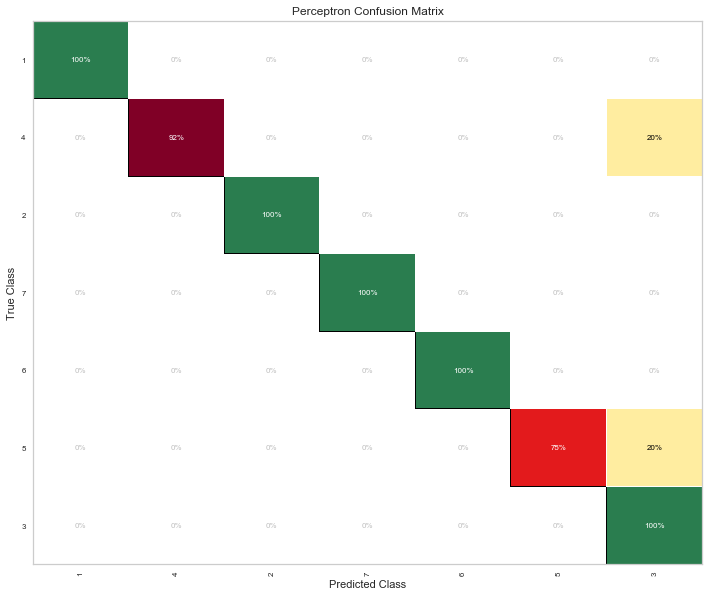

In [192]:
from sklearn.linear_model import Perceptron
from yellowbrick.classifier import ConfusionMatrix
perc = Perceptron(random_state=42)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(perc, classes=animals.class_type.unique())
cm.fit(X, y).score(X, y)
fig = cm.poof()

The confusion matrix shows us that our data is not linearly separable. We mistook a fish for a reptile and a reptile for an amphibian.

## Linear Discriminant Analysis + Computational Geometry
The model will basically draw lines through the outer points of each class in lower-dimensional space to create the smallest possible polygon that encapsulates every point in the class. If any of the shapes overlap, the data is not linearly separable. To detect overlap, we use what's called the convex hull algorithm. The picture below demonstrates this concept:


![img](../img/linear_separability_demonstration.jpg)

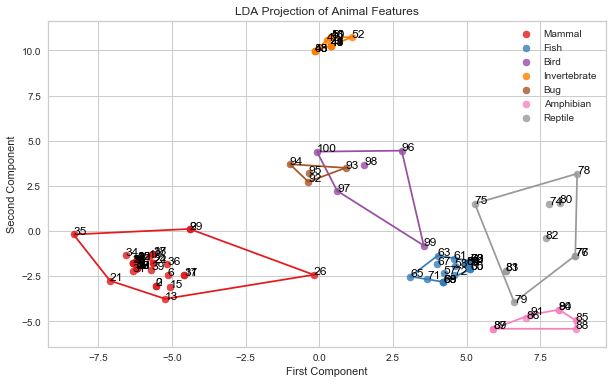

In [194]:
from scipy.spatial import ConvexHull
import pylab as pl

X_r = LDA(n_components=2).fit_transform(X, y)

plt.clf()
plt.figure(figsize = (10, 6))
targets = animals.class_name.unique()
plt.title('LDA Projection of Animal Features')
plt.xlabel('First Component')
plt.ylabel('Second Component')

for color, i, target in zip(colors, np.arange(1, n_classes+1), targets):
    bucket = X_r[y == i, :]
    hull = ConvexHull(bucket)
    coords = list(zip(bucket[:,0], bucket[:,1], animals[animals.class_type == i].index))
    plt.scatter(bucket[:, 0], bucket[:, 1], color=color, alpha=.8, lw=.5, label=target)
    for x1,x2,ind in coords:
        pl.text(x1, x2, str(ind), color='black', fontsize=12)
    for j in hull.simplices:
        plt.plot(bucket[j,0], bucket[j,1], color)
plt.legend()
plt.show()

In [174]:
animal_names[93]

'vampire'

Turns out there's a vampire (bug) that's ruining all our fun...AKA linear separability!

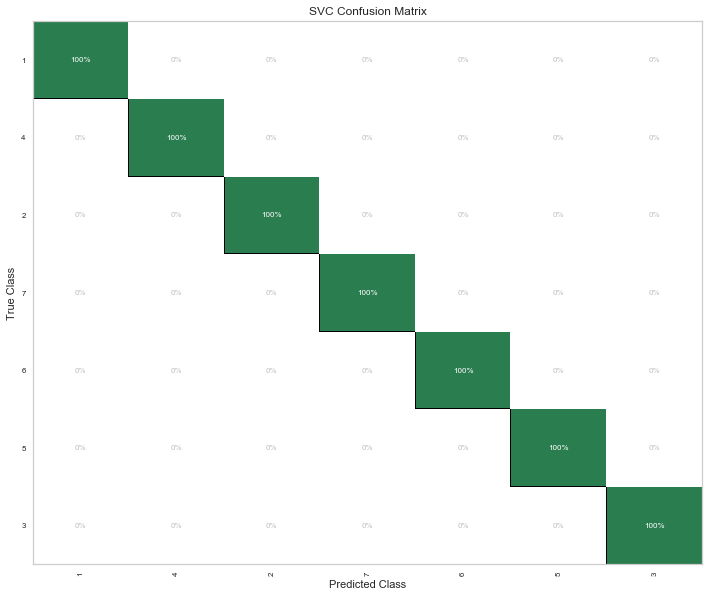

In [203]:
from sklearn.svm import SVC
svc = SVC(kernel='linear', random_state=42)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(svc, classes=animals.class_type.unique())
cm.fit(X, y).score(X, y)
fig = cm.poof()

Sweet baby jesus we've done it. We have linear separability!

In [204]:
svc.get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### Linear Discriminant Analysis + Support Vector Machine (Linear Kernel)

Just for fun, let's see what happens when we transform our data with LDA before classifying it.

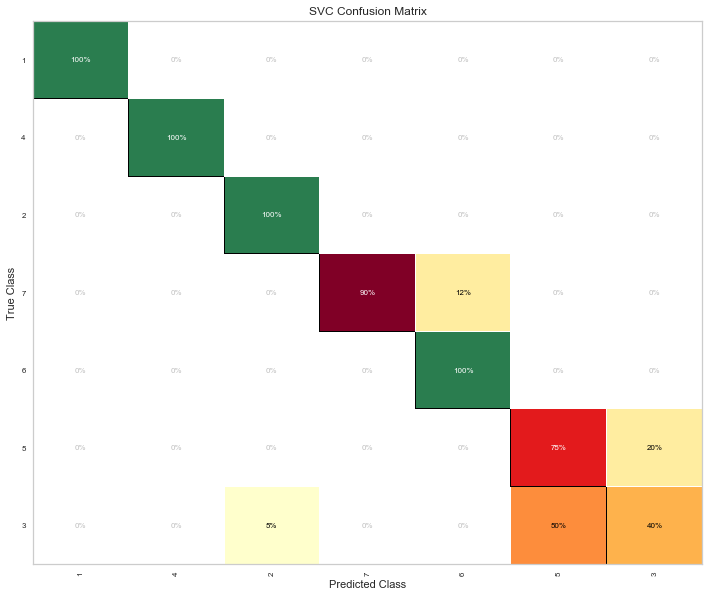

In [201]:
from sklearn.pipeline import make_pipeline
svc = make_pipeline(LDA(n_components=2), SVC(C=1, kernel='linear', random_state=42))

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(svc, classes=animals.class_type.unique())
cm.fit(X, y).score(X, y)
fig = cm.poof()

We can't seem to get our amphibians and reptiles straight! This is not surprising given that we only have 4 and 5 observations for each respective class.

Let's see how an SVM with a non-linear kernel performs.

### Linear Discriminant Analysis + Support Vector Machine (Non-linear Kernel)

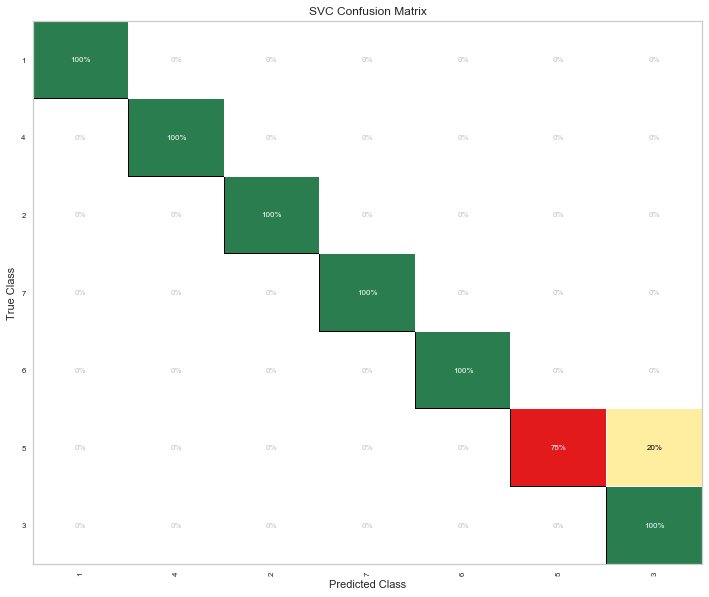

In [202]:
svc = make_pipeline(LDA(n_components=2), SVC(C=1, kernel='rbf', random_state=42))

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(svc, classes=animals.class_type.unique())
cm.fit(X, y).score(X, y)
fig = cm.poof()

That's certainly an improvement over the previous iteration, but it's still pointless...we don't need to transform the data set if it's perfectly linearly separable. However, maybe it could help to generalize our model?

# SVM Hyperparameter Tuning

Now that we know the dataset is linearly separable, let's cross-validate the model to find the optimal hyperparameters. Although we performed perfectly on all of the data with a linear kernel, other kernels might generalize better, so the hyperparameters of interest will be **C**, **gamma**, and **kernel**.

In [210]:
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42) 

Cs = [.001, .01, .1, 1, 10]
gammas = [.001, .01, .1, 1]
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

param_grid = {'C':Cs, 'gamma':gammas, 'kernel':kernels}

n_folds = 3 # Number of folds must be less than number of obs in smallest class
grid_search = GridSearchCV(SVC(), param_grid, cv=n_folds)
grid_search.fit(X_train, y_train)

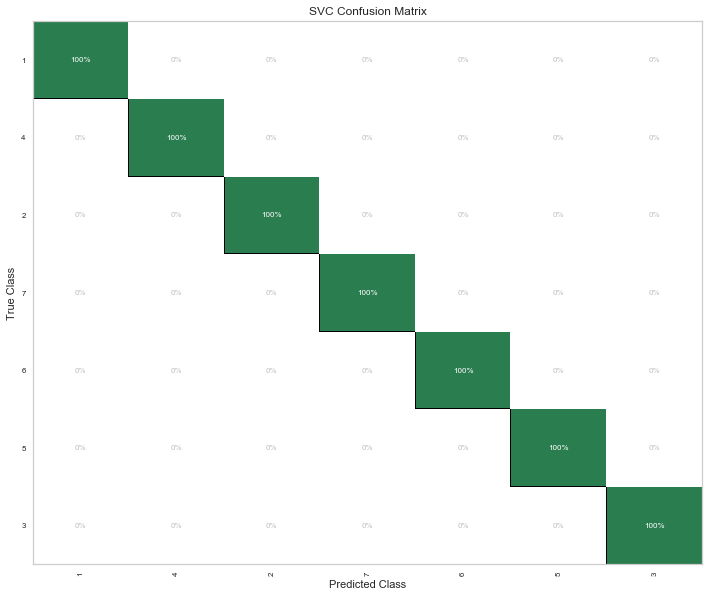

In [214]:
svc = SVC(**grid_search.best_params_)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(svc, classes=animals.class_type.unique())
cm.fit(X_train, y_train).score(X_test, y_test)
fig = cm.poof()

Alrighty then! It looks like my work here is done...we predicted test set perfectly. Based on the cross-validation, our optimal hyperparameters were a C of .1, gamma of 1, and polynomial kernel.

# K Nearest Neighbors Classifier

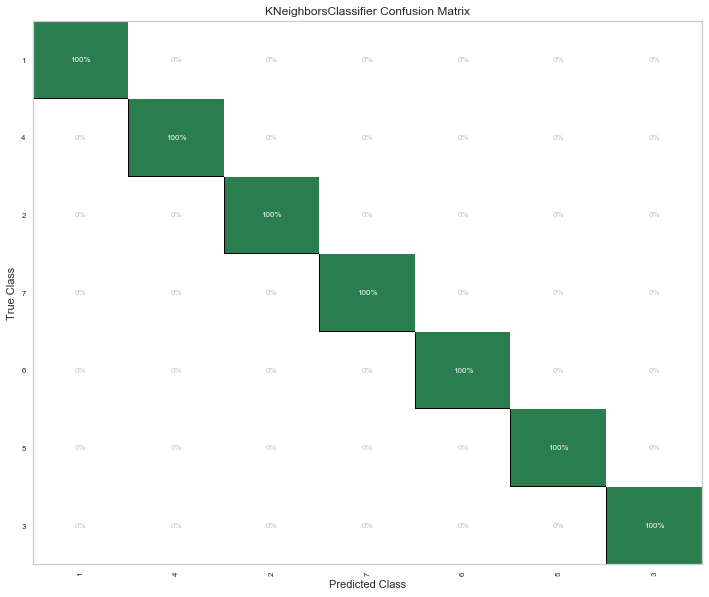

In [242]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(1)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(knc, classes=animals.class_type.unique())
cm.fit(X, y).score(X, y)
fig = cm.poof()

# K Nearest Neighbors Cross-validation

In [245]:
n_neighbors = np.arange(1, 6)
metrics = ['euclidean', 'minkowski', 'jaccard', 'dice']
param_grid = {'n_neighbors': n_neighbors, 'metric':metrics}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=n_folds)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([1, 2, 3, 4, 5]), 'metric': ['euclidean', 'minkowski', 'jaccard', 'dice']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

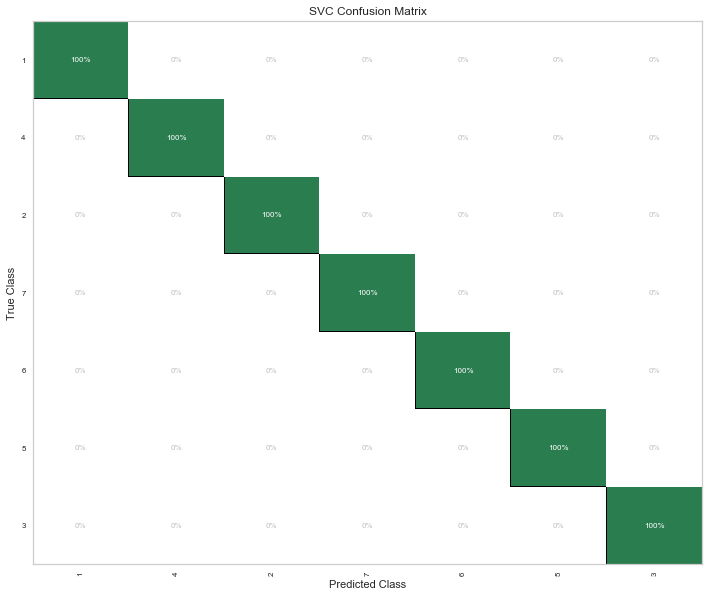

In [246]:
knc = KNeighborsClassifier(**grid_search.best_params_)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(svc, classes=animals.class_type.unique())
cm.fit(X_train, y_train).score(X_test, y_test)
fig = cm.poof()

Let's see if we just got lucky with our cross-validation by simulating a variety of random seeds for splitting the data into test and train.

In [274]:
def test_model(seed, est):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed)
    if est == 'svc':
        model = SVC(C=.1, gamma=1, kernel='poly').fit(X_train, y_train)
    elif est == 'knc':
        model = KNeighborsClassifier(n_neighbors=3, metric='euclidean').fit(X_train, y_train)
    else:
        raise ValueError('est parameter must be svc or knc')
    return model.score(X_test, y_test)

In [275]:
def simulate_model(n_simulations, est):
    scores = []
    for seed in range(n_simulations):
        scores.append(test_model(seed, est.lower()))
    print('The average accuracy for ' + est.upper() + ' across {} simulations was {:.2%}'.format(n_simulations, np.mean(scores)))

In [276]:
n_simulations = 1000
simulate_model(n_simulations, 'KNC')

The average accuracy for KNC across 1000 simulations was 95.07%


| Model | Accuracy |
|-------|----------|
| SVC   | 97.57%   |
| KNC   | 95.10%   |

# Next Steps

We can see if a neural net or gradient boosting machine will perform better using the same approach as above. However, these algorithms have a require more complicated hyperparameter tuning.